# Inventory Monitoring at Distribution Centers

In [2]:
import boto3
import json
import os
from tqdm import tqdm
from PIL import Image
import pandas as pd

In [3]:
!pip install -q torch 
!pip install -q smdebug

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [4]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

# download_and_arrange_data()

## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [57]:

total_num_obj = []
labels = []
for num_obj in range(1,6):
    subfolder = f'train_data/{num_obj}'
    num_images = !ls $subfolder
    labels.append(num_obj)
    total_num_obj.append(len(num_images))
    print(f'There has {len(num_images)} images under {subfolder}')
print(f'\nThere has {sum(total_num_obj)} images in total which accounts for {sum(total_num_obj)/500000*100}% of the whole dataset\n')

total_no_of_image = sum(total_num_obj)
cnt_pcnt = []

label_dist = pd.DataFrame(data = {'label': labels, 'number_of_image': total_num_obj})
label_dist['percentage(%)'] = label_dist['number_of_image'].apply(lambda x: f'{x/total_no_of_image*100:.2f}%')
for cnt, pcnt in zip(label_dist['number_of_image'], label_dist['percentage(%)']):
    cnt_pcnt.append(f'{cnt} ({pcnt})')
label_dist['display'] = cnt_pcnt

print('\nLabel distribution stat')
label_dist

There has 1228 images under train_data/1
There has 2299 images under train_data/2
There has 2666 images under train_data/3
There has 2373 images under train_data/4
There has 1875 images under train_data/5

There has 10441 images in total which accounts for 2.0882% of the whole dataset


Label distribution stat


label  number_of_image percentage(%)        display
0      1             1228        11.76%  1228 (11.76%)
1      2             2299        22.02%  2299 (22.02%)
2      3             2666        25.53%  2666 (25.53%)
3      4             2373        22.73%  2373 (22.73%)
4      5             1875        17.96%  1875 (17.96%)

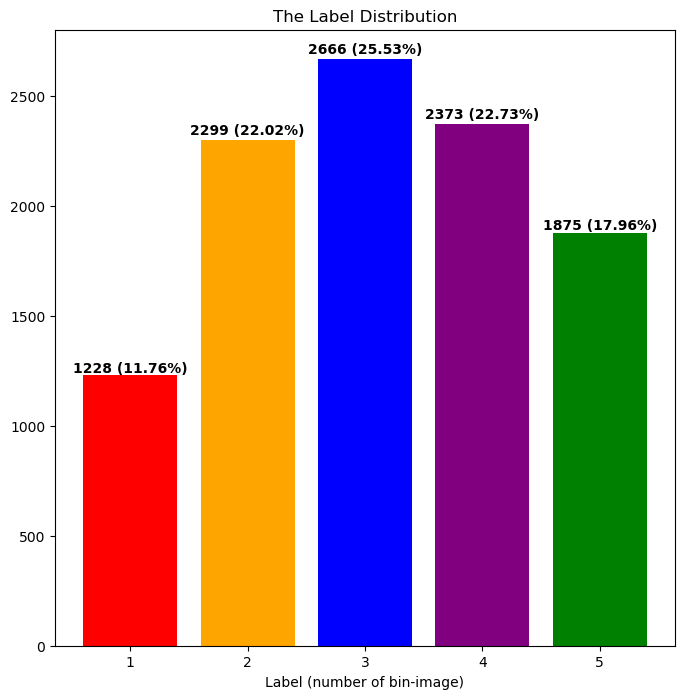

In [112]:
# visualize the label distribution

plt.figure(figsize=(8,8))
colors_list = ['Red','Orange', 'Blue', 'Purple', 'Green']
graph = plt.bar(label_dist.label,label_dist.number_of_image, color = colors_list)
plt.title('The Label Distribution')

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(label_dist.display[i]),
             ha='center',
             weight='bold')
    i+=1
plt.xlabel("Label (number of bin-image)")
plt.show()

# plt.savefig('The Label Distribution.png')

In [93]:
import os
import glob

def get_files(filepath, pattern='*.jpg'):
    all_files = []
    for root, dirs, files in os.walk(filepath):
        files = glob.glob(os.path.join(root,pattern))
        for f in files :
            all_files.append(os.path.abspath(f))
    
    return all_files


In [95]:
def random_choice(pattern):
    import random
    random.seed(42)    
    image_file_list = get_files('train_data', pattern)

    random_samples = random.choices(image_file_list, k=2)
    return random_samples

**Check 2 sample images with 5 objects (label=5)**

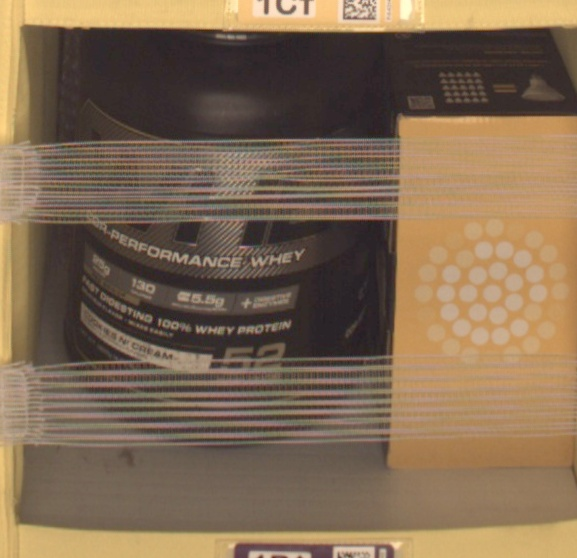

In [99]:
random_samples_label_5 = random_choice('5/*.jpg')
Image.open(random_samples_label_5[0])

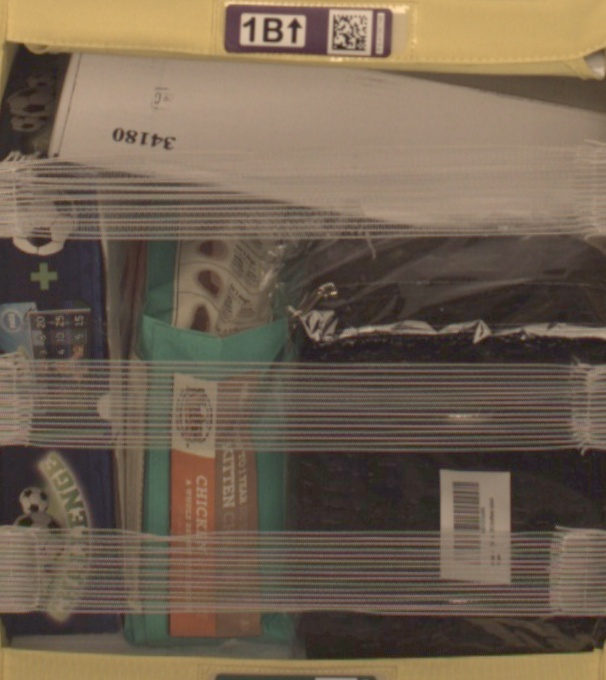

In [97]:
Image.open(random_samples_label_5[1])

**Check 2 sample images with 4 objects (label=4)**

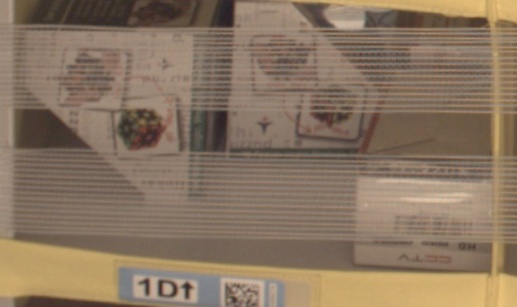

In [100]:
random_samples_label_4 = random_choice('4/*.jpg')
Image.open(random_samples_label_4[0])

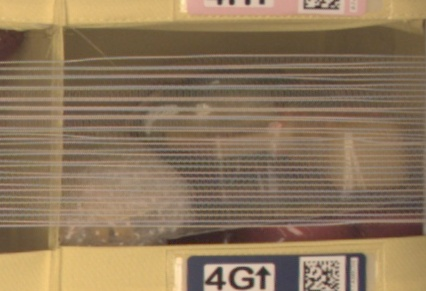

In [101]:
Image.open(random_samples_label_4[1])

**Check 2 sample images with 3 objects (label=3)**

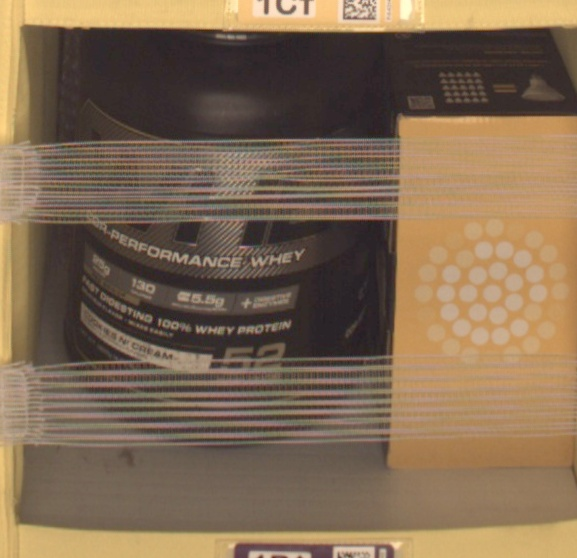

In [102]:
random_samples_label_3 = random_choice('3/*.jpg')
Image.open(random_samples_label_5[0])

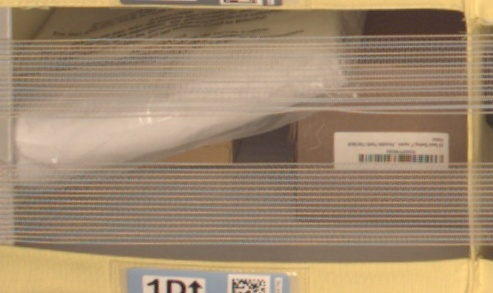

In [103]:
Image.open(random_samples_label_3[1])

**Check 2 sample images with 2 objects (label=2)**

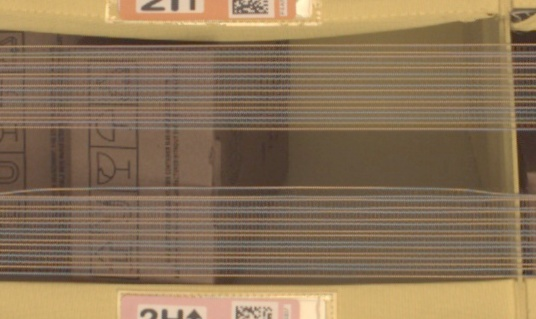

In [104]:
random_samples_label_2 = random_choice('2/*.jpg')
Image.open(random_samples_label_2[0])

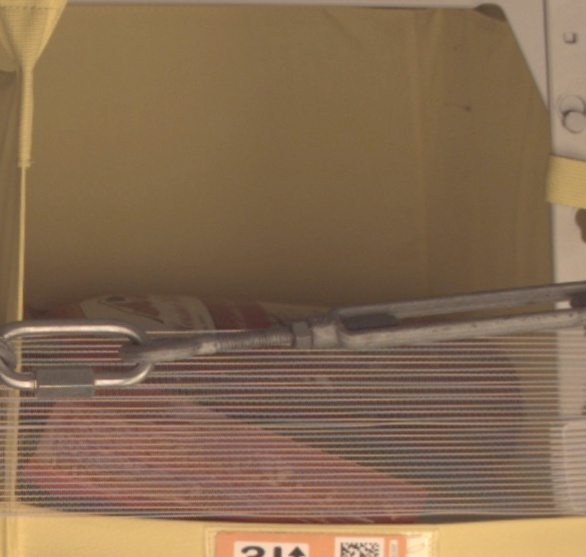

In [105]:
Image.open(random_samples_label_2[1])

**Check 2 sample images with 1 object (label=1)**

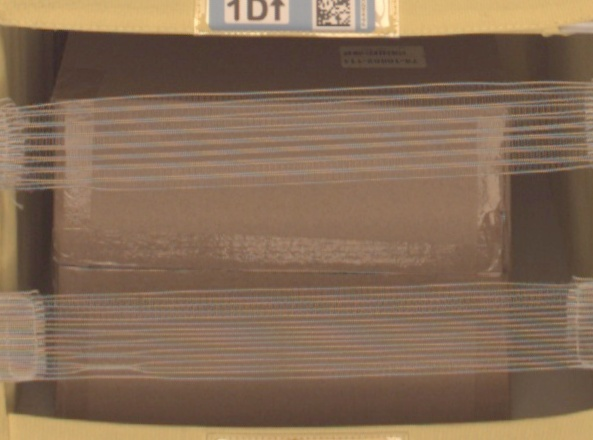

In [106]:
random_samples_label_1 = random_choice('1/*.jpg')
Image.open(random_samples_label_1[0])

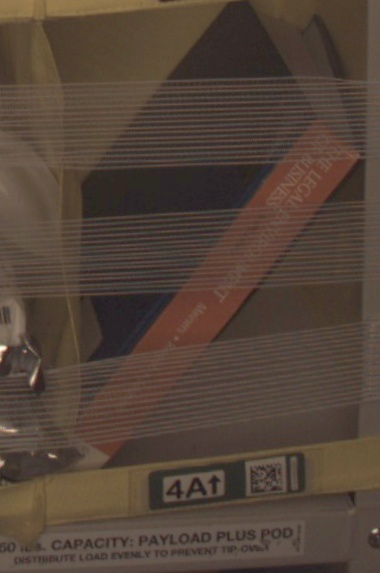

In [107]:
Image.open(random_samples_label_1[1])

## Split into Train/Test/Validation 

In [15]:
# Firstly, we need to create train, test and validation folders with 5 subfolders(1, 2, 3, 4, 5)
split_types = ['train', 'test', 'validation']
labels = range(1, 6)

dataset_folder = 'amazon_bin_images'

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)
    print(f'Successfully created a new folder - {dataset_folder}')

for split_type in split_types:
    for label in labels:
        path = os.path.join(dataset_folder, split_type, str(label))
        if not os.path.exists(path):
            os.makedirs(path, exist_ok=True)
            print(f'Successfully created the {path}')
          

Successfully created a new folder - amazon_bin_images
Successfully created the amazon_bin_images/train/1
Successfully created the amazon_bin_images/train/2
Successfully created the amazon_bin_images/train/3
Successfully created the amazon_bin_images/train/4
Successfully created the amazon_bin_images/train/5
Successfully created the amazon_bin_images/test/1
Successfully created the amazon_bin_images/test/2
Successfully created the amazon_bin_images/test/3
Successfully created the amazon_bin_images/test/4
Successfully created the amazon_bin_images/test/5
Successfully created the amazon_bin_images/validation/1
Successfully created the amazon_bin_images/validation/2
Successfully created the amazon_bin_images/validation/3
Successfully created the amazon_bin_images/validation/4
Successfully created the amazon_bin_images/validation/5


In [27]:
# Secondly, we need to copy images into the specified folders with 80% for training, 10% for test and 10% for validation

import shutil

def split_dataset(train_size=0.8, split_validation=True):
    
    images_dict = {}
    
    for split_type in split_types:
        
        for label in labels:
            dataset = os.listdir(os.path.join('train_data', str(label)))
            dataset_len = len(dataset)
            train_len = round(train_size*dataset_len)
            images_dict['train'] = dataset[:train_len]
            
            if split_validation:
                test_size = (1-train_size)/2
                test_len = round(test_size*dataset_len)
                validation_len = dataset_len - train_len - test_len
                images_dict['test'] = dataset[train_len:train_len+test_len]
                images_dict['validation'] = dataset[train_len+test_len:]            
            else:
                images_dict['test'] = dataset[train_len:]
                images_dict['validation'] = []
            
            base = os.path.join('train_data', str(label))
            dest = os.path.join('amazon_bin_images', split_type, str(label))
            print(f'Copying data from {base} to {dest}\n===>')
                  
            for file in images_dict[split_type]:
                base_file_path = base + '/' + file
                dest_file_path = dest + '/' + file
                
                if 'ipynb' not in base_file_path:
                    shutil.copy(base_file_path, dest_file_path)
                    
            print(f'Successfully copied the images into {dest}!\n')
                            
                                       

In [28]:
split_dataset()

Copying data from train_data/1 to amazon_bin_images/train/1
===>
Successfully copied the images into amazon_bin_images/train/1!

Copying data from train_data/2 to amazon_bin_images/train/2
===>
Successfully copied the images into amazon_bin_images/train/2!

Copying data from train_data/3 to amazon_bin_images/train/3
===>
Successfully copied the images into amazon_bin_images/train/3!

Copying data from train_data/4 to amazon_bin_images/train/4
===>
Successfully copied the images into amazon_bin_images/train/4!

Copying data from train_data/5 to amazon_bin_images/train/5
===>
Successfully copied the images into amazon_bin_images/train/5!

Copying data from train_data/1 to amazon_bin_images/test/1
===>
Successfully copied the images into amazon_bin_images/test/1!

Copying data from train_data/2 to amazon_bin_images/test/2
===>
Successfully copied the images into amazon_bin_images/test/2!

Copying data from train_data/3 to amazon_bin_images/test/3
===>
Successfully copied the images into a

In [35]:
# Check the data size for each folder again
for split_type in split_types:
    total_num_obj = []
    for label in range(1,6):
        subfolder = f'amazon_bin_images/{split_type}/{label}'
        num_images = !ls $subfolder
        total_num_obj.append(len(num_images))
        print(f'There has {len(num_images)} images under {subfolder}')
    print(f'\nThere has {sum(total_num_obj)} images in {split_type} in total\n')

There has 982 images under amazon_bin_images/train/1
There has 1839 images under amazon_bin_images/train/2
There has 2133 images under amazon_bin_images/train/3
There has 1898 images under amazon_bin_images/train/4
There has 1500 images under amazon_bin_images/train/5

There has 8352 images in train in total

There has 123 images under amazon_bin_images/test/1
There has 230 images under amazon_bin_images/test/2
There has 267 images under amazon_bin_images/test/3
There has 237 images under amazon_bin_images/test/4
There has 188 images under amazon_bin_images/test/5

There has 1045 images in test in total

There has 123 images under amazon_bin_images/validation/1
There has 230 images under amazon_bin_images/validation/2
There has 266 images under amazon_bin_images/validation/3
There has 238 images under amazon_bin_images/validation/4
There has 187 images under amazon_bin_images/validation/5

There has 1044 images in validation in total



In [37]:
#Upload the data to AWS S3
!aws s3 cp amazon_bin_images s3://amazon-bin-images-subset/ --quiet --recursive

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [12]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values


from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

# assigning S3 paths for the training job
bucket='amazon-bin-images-subset'

s3_data = "s3://{}".format(bucket)
# s3_output_dir = "s3://{}/{}/".format(bucket, "output")
# s3_model_dir = "s3://{}/{}/".format(bucket, "model-artifacts/model")

# os.environ['SM_CHANNEL_TRAIN']= s3_data
# os.environ['SM_MODEL_DIR']= s3_model_dir
# os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir

role = get_execution_role()

hyperparameters = {
    "batch_size": 64,
    "num_classes": 5,
    "lr": 0.01,
    "epochs": 2
}


In [13]:
#TODO: Create your training estimator

estimator = PyTorch(
    entry_point="train.py",
    role=role,
    framework_version ='1.6',
    py_version='py36',
    instance_count=1,
    instance_type="ml.g4dn.12xlarge",
    code_location='s3://sagemaker-deployment-project/model-artifacts/source',
    hyperparameters=hyperparameters
)



In [14]:
# TODO: Fit your estimator

estimator.fit({"train": s3_data})

2022-12-16 09:08:07 Starting - Starting the training job...
2022-12-16 09:08:31 Starting - Preparing the instances for trainingProfilerReport-1671181687: InProgress
......
2022-12-16 09:09:38 Downloading - Downloading input data...
2022-12-16 09:09:58 Training - Downloading the training image......
2022-12-16 09:10:52 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-16 09:11:24,597 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-16 09:11:24,643 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-16 09:11:24,645 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-12-16 09:11:24,946 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
 

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [15]:
#TODO: Create your hyperparameter search space
from sagemaker.tuner import (
    IntegerParameter, 
     ContinuousParameter,
     CategoricalParameter, 
     HyperparameterTuner
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128]),
}

In [16]:
#TODO: Create your training estimator

from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

role = get_execution_role()

# Create a estimator
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    framework_version ='1.6',
    py_version='py36',
    instance_count=1,
    instance_type="ml.g4dn.12xlarge",
    code_location='s3://sagemaker-deployment-project/model-artifacts/source',
)


objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}] 

# Create a tuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [17]:
# TODO: Fit your estimator
tuner.fit({"train": s3_data})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................................................................................................................................................................!


In [18]:
# TODO: Find the best hyperparameters

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-12-16 10:06:37 Starting - Found matching resource for reuse
2022-12-16 10:06:37 Downloading - Downloading input data
2022-12-16 10:06:37 Training - Training image download completed. Training in progress.
2022-12-16 10:06:37 Uploading - Uploading generated training model
2022-12-16 10:06:37 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'lr': '0.0018788785870785117',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-12-16-09-49-01-308"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-deployment-project/model-artifacts/source/pytorch-training-2022-12-16-09-49-01-308/source/sourcedir.tar.gz"'}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [19]:
# TODO: Set up debugging and profiling rules and hooks

from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerRule,
    CollectionConfig,
)

rules = [
    # debugging
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    # profiling
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

metric_definitions = [{"Name": "Train Loss", "Regex": "Train Loss: ([0-9\\.]+)"},{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

hyperparameters={
    'lr': 0.0018788785870785117,
    'batch_size': 64,
}

In [20]:
# TODO: Create and fit an estimator
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

role= get_execution_role()

# Create a estimator
estimator = PyTorch(
    entry_point="finetuner-debugger.py",
    role=role,
    framework_version ='1.6',
    py_version='py36',
    instance_count=1,
    instance_type="ml.g4dn.12xlarge",
    code_location='s3://sagemaker-deployment-project/model-artifacts',
    hyperparameters=hyperparameters,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config,
    rules=rules,
    metric_definitions = metric_definitions,
)

estimator.fit({'train' : s3_data},wait=True)

2022-12-16 10:21:36 Starting - Starting the training job...
2022-12-16 10:22:05 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-12-16 10:23:05 Downloading - Downloading input data...
2022-12-16 10:23:26 Training - Downloading the training image......
2022-12-16 10:24:26 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-16 10:24:54,698 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-16 10:24:54,745 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-16 10:24:54,748 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-12-16 10:24:55,059 sagemaker-training-toolkit INFO     Invoking

In [23]:
# TODO: Plot a debugging output.
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

Training jobname: pytorch-training-2022-12-16-10-21-35-775
[2022-12-16 10:39:06.934 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-16 10:39:06.948 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-526539017075/pytorch-training-2022-12-16-10-21-35-775/debug-output
[2022-12-16 10:39:10.016 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-12-16 10:39:11.037 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


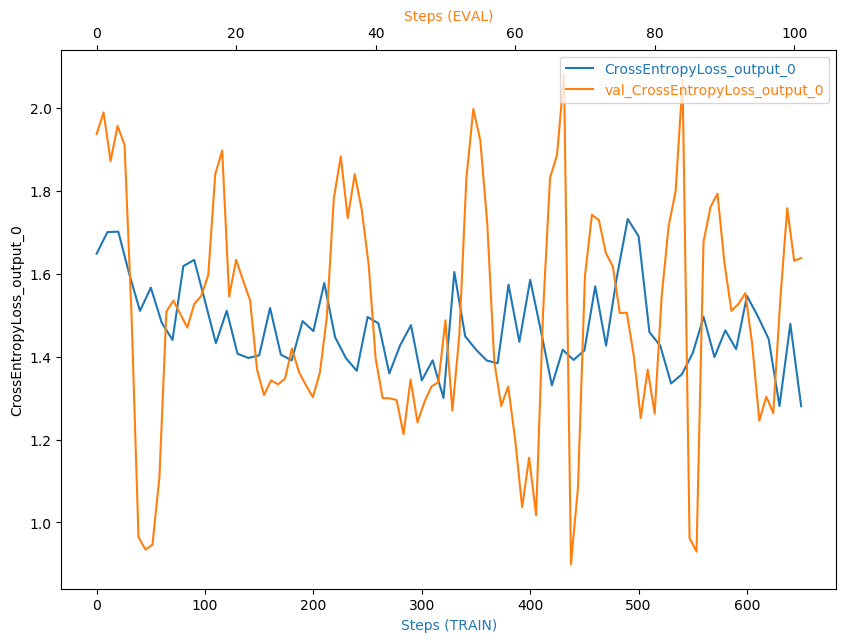

In [24]:

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [25]:
# TODO: Display the profiler output

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path


's3://sagemaker-us-east-1-526539017075/pytorch-training-2022-12-16-10-21-35-775/rule-output'

In [26]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-526539017075/pytorch-training-2022-12-16-10-21-35-775/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-526539017075/pytorch-training-2022-12-16-10-21-35-775/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-526539017075/pytorch-training-2022-12-16-10-21-35-775/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-526539017075/pytorch-training-2022-12-16-10-21-35-775/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-526539017075/

In [27]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:526539017075:processing-job/pytorch-training-2022-12-1-vanishinggradient-295c53e7',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2022, 12, 16, 10, 33, 30, 441000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:526539017075:processing-job/pytorch-training-2022-12-1-overfit-edbf86be',
  'RuleEvaluationStatus': 'Error',
  'StatusDetails': 'InternalServerError: We encountered an internal error. Please try again.',
  'LastModifiedTime': datetime.datetime(2022, 12, 16, 10, 33, 30, 441000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overtraining',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:526539017075:processing-job/pytorch-training-2022-12-1-overtraining-7e4c7f3f',
  'RuleEvaluationStatus': 'Error',
  'StatusDetails': 'InternalServerError: We encountered an internal error

In [28]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [29]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [30]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [44]:
# TODO: Deploy your model to an endpoint

model_location= "s3://amazon-bin-images-subset/model/model.tar.gz" 

import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
import torch
import numpy as np

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
        
pytorch_model = PyTorchModel(
    model_data=model_location, 
    role=get_execution_role(), 
    entry_point='inference.py',
    py_version='py3',
    framework_version='1.6',
    predictor_cls=ImagePredictor) 

In [45]:
# TODO: Run an prediction on the endpoint
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

-------!

Original image:


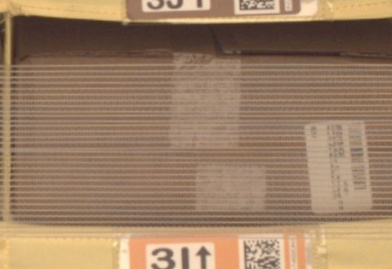


The orginal image label: 1
The prediction label: 3


Original image:


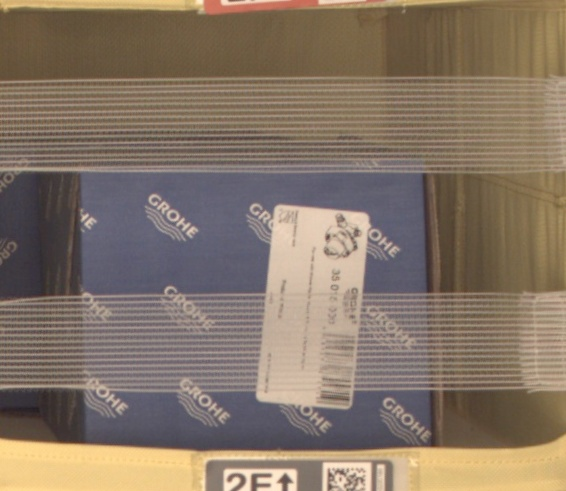


The orginal image label: 2
The prediction label: 2


Original image:


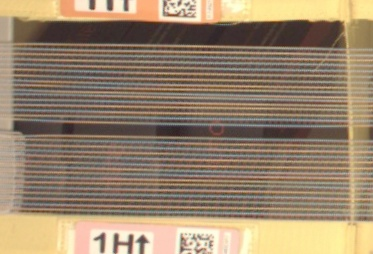


The orginal image label: 3
The prediction label: 3


Original image:


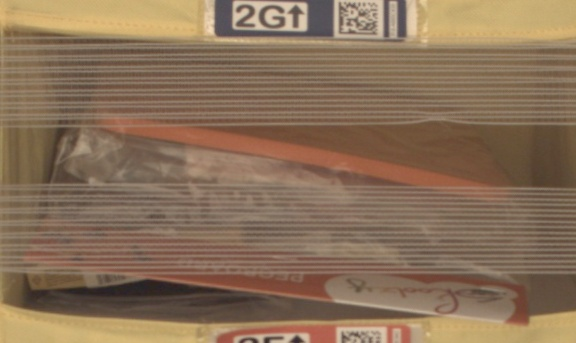


The orginal image label: 4
The prediction label: 3


Original image:


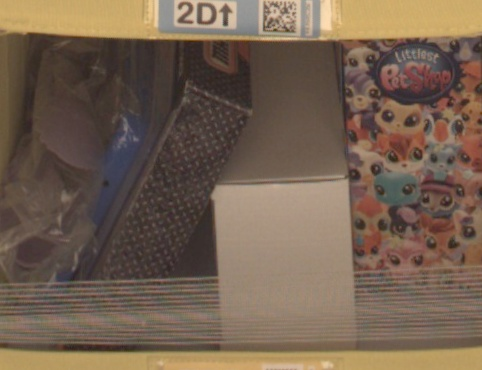


The orginal image label: 5
The prediction label: 2




In [53]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
from IPython.display import display

files = ["./amazon_bin_images/test/1/00048.jpg",
         "./amazon_bin_images/test/2/01689.jpg",
         "./amazon_bin_images/test/3/00633.jpg",
         "./amazon_bin_images/test/4/09623.jpg",
         "./amazon_bin_images/test/5/104304.jpg"        
        ]
for file in files:
    label = file.split('/')[-2]
    with open(file, "rb") as f:
        payload = f.read()

    response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})

    img = Image.open(file)
    print('Original image:')
    display(img) 
    print(f'\nThe orginal image label: {label}')
    print(f'The prediction label: {np.argmax(response, 1)[0]}\n\n')
    # print(f'prediction:\n {response}')



In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance